In [1]:
!pip install qiskit
!pip install pylatexenc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.5 MB 10.1 MB/s 
     |████████████████████████████████| 18.0 MB 136 kB/s 
     |████████████████████████████████| 240 kB 46.9 MB/s 
     |████████████████████████████████| 198 kB 14.0 MB/s 
     |████████████████████████████████| 54 kB 2.0 MB/s 
     |████████████████████████████████| 112 kB 29.9 MB/s 
     |████████████████████████████████| 1.6 MB 44.2 MB/s 
     |████████████████████████████████| 49 kB 4.1 MB/s 
     |████████████████████████████████| 943 kB 37.6 MB/s 
     |████████████████████████████████| 49 kB 4.4 MB/s 
     |████████████████████████████████| 38.1 MB 1.4 MB/s 
     |████████████████████████████████| 37.5 MB 2.3 MB/s 
     |████████████████████████████████| 4.0 MB 30.8 MB/s 
     |████████████████████████████████| 112 kB 23.2 MB/s 
  Created wheel for qiskit: filename=qiskit-0.36.2-py3-none-any.whl size=11933 sha256=f328a0a9d

gamma = 1, percentile = 9.54, test val train

## Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load from Drive

Load from drive .mat file

In [3]:
!pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
#Loading .mat Cardiotocography dataset file
!gdown --id 1j4qIus2Bl44Om0UiOu4o4f__wVwUeDfP

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1j4qIus2Bl44Om0UiOu4o4f__wVwUeDfP
To: /content/cardio.mat
100% 68.3k/68.3k [00:00<00:00, 64.3MB/s]


In [8]:
import numpy as np
from time import time
from sklearn.kernel_approximation import RBFSampler
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt


from scipy import io

cardio = io.loadmat("cardio.mat")

cardio["X"].shape, cardio["y"].shape

((1831, 21), (1831, 1))

In [9]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import Aer, execute

Preprocessing

np.load object --> X, y (scaled)

normal: '1'  
anomalies: '0'

In [10]:
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import zscore

def preprocessing_cardio(data):
  features, labels = cardio["X"], cardio["y"]
  labels = 1 - labels
  return features, labels

cardio_X, cardio_y = preprocessing_cardio(cardio)

cardio_X.shape, cardio_y.shape

((1831, 21), (1831, 1))

Random fourier features

parameters: gamma, dimensions, random_state

X --> rff(X)

In [11]:
from sklearn.kernel_approximation import RBFSampler
"""
  Code from https://arxiv.org/abs/2004.01227
"""
class QFeatureMap: 

  def get_dim(self, num_features):
    pass

  def batch2wf(self, X):
    pass

  def batch2dm(self, X):
    psi = self.batch2wf(X)
    rho = np.einsum('...i,...j', psi, np.conj(psi))
    return rho

class QFeatureMap_rff(QFeatureMap):

  def __init__(self, rbf_sampler):
    self.rbf_sampler = rbf_sampler
    self.weights = np.array(rbf_sampler.random_weights_)
    self.offset = np.array(rbf_sampler.random_offset_)
    self.dim = rbf_sampler.get_params()['n_components']

  def get_dim(self, num_features):
    return self.dim

  def batch2wf(self, X):
    vals = np.dot(X, self.weights) + self.offset
    vals = np.cos(vals)
    vals *= np.sqrt(2.) / np.sqrt(self.dim)
    norms = np.linalg.norm(vals, axis=1)
    psi = vals / norms[:, np.newaxis]
    return psi

In [12]:
# Create the RandomFourierFeature map
def rff(X, dim, gamma): 
    feature_map_fourier = RBFSampler(gamma=gamma, n_components=dim, random_state=None)
    X_feat_train = feature_map_fourier.fit(cardio_X)

    rffmap = QFeatureMap_rff(rbf_sampler=feature_map_fourier)
    Crff = rffmap.batch2wf(cardio_X)

    return Crff

Train test split

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(cardio_X, cardio_y, test_size=0.2, stratify=cardio_y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train, random_state=42)

print(f"shape of X_train: {X_train.shape} X_test: {X_test.shape} X_val {X_val.shape}")
n_classes = np.bincount(y_test.ravel().astype(np.int64))

print(f"classes: 0: {n_classes[0]} 1: {n_classes[1]} %-anomalies: {n_classes[0] / (n_classes[0] + n_classes[1])}")
#print(f"classes: 0: {n_classes[0]} 1: {n_classes[1]} %-anomalies: {n_classes[1] / (n_classes[0] + n_classes[1])}")

shape of X_train: (1098, 21) X_test: (367, 21) X_val (366, 21)
classes: 0: 35 1: 332 %-anomalies: 0.09536784741144415


## Quantum Prediction

Density Matrix Build

Pure State: x_train --> U (matrix)

Mixed State: X_train --> lambda (vec) , U (matrix)

In [14]:
def pure_state(Ctrain):
    phi_train = np.sum(Ctrain, axis=0)
    phi_train = phi_train / np.linalg.norm(phi_train)

    size_U = len(phi_train)
    U_train = np.zeros((size_U, size_U))
    x_1 = phi_train
    U_train[:, 0] = x_1
    for i in range(1, size_U):
        x_i = np.random.randn(size_U)
        for j in range(0, i):
            x_i -= x_i.dot(U_train[:, j]) * U_train[:, j]
        x_i = x_i / np.linalg.norm(x_i)
        U_train[:, i] = x_i

    return U_train

In [15]:
import copy

def mixed_state(Ctrain):
    
    Z_train = np.outer(Ctrain[0], Ctrain[0])
    for i in range(1, len(Ctrain)):
        Z_train += np.outer(Ctrain[i], Ctrain[i])


    Z_train *= 1/len(Ctrain)

    lambda_P1_temp, U_train = np.linalg.eigh(Z_train)

    return lambda_P1_temp, U_train

Running the Quantum Circuits

parameters: eigvals, U, n_shots

X_test --> preds

In [16]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import Aer, execute

In [17]:
backend2 = Aer.get_backend('qasm_simulator')
# np.random.seed(1234)

In [18]:
def quantum_circuit_mixed_four(Ctest, eigvals, U_train, n_shots=10000):

    Cpred = []
    for i in range(len(Ctest)):
        qc = QuantumCircuit(4, 2)

        qc.initialize(Ctest[i], [0, 1])
        qc.initialize(np.sqrt(eigvals), [2, 3])
        qc.isometry(U_train.T, [], [0, 1]) 

        qc.cnot(3, 1)
        qc.cnot(2, 0)

        qc.measure(0, 0)
        qc.measure(1, 1)

        counts = execute(qc, backend2, shots=n_shots).result().get_counts()
        try:
            Cpred.append(counts['00'] / n_shots)
        except:
            Cpred.append(0)

    return Cpred

In [19]:
def quantum_circuit_pure_four(Ctest, U_train, n_shots=10000):
    
    Cpred = []
    for i in range(len(Ctest)):
        qc = QuantumCircuit(2, 2)

        qc.initialize(Ctest[i], [0, 1])
        qc.isometry(U_train.T, [], [0, 1]) # ArbRot as a isometry

        qc.measure(0, 0)
        qc.measure(1, 1)

        counts = execute(qc, backend2, shots=n_shots).result().get_counts()
        try:
            Cpred.append(np.sqrt(counts['00'] / n_shots))
        except:
            Cpred.append(0)

    return Cpred

Classification

The threshold is calculated using weighted f1_score

X_test --> classification_report, threshold

In [20]:
from sklearn.metrics import roc_curve, f1_score
from sklearn.metrics import classification_report

def classification(preds_val, preds_test, y_test):

    thredhold = np.percentile(preds_val, q = 9.54)
    y_pred = preds_test > thredhold
    return classification_report(y_test, y_pred, digits=4)

In [ ]:
gammas = [0.0078125]
dim = 4
num_exps = 5
exp_time = time()
for gamma in gammas:
    for i in range(num_exps):
        print("4x4 Pure, experiment", i)
        print("Gamma:", gamma)

        feature_map_fourier = RBFSampler(gamma=gamma, n_components=dim) # original gamma 2
        X_feat_train = feature_map_fourier.fit(X_train)
        rffmap = QFeatureMap_rff(rbf_sampler=feature_map_fourier)
        X_feat_train = rffmap.batch2wf(X_train)
        X_feat_val = rffmap.batch2wf(X_val)
        X_feat_test = rffmap.batch2wf(X_test)

        U = pure_state(X_feat_train)

        preds_val = quantum_circuit_pure_four(X_feat_val, U)
        preds_test = quantum_circuit_pure_four(X_feat_test, U)

        print(classification(preds_val, preds_test, y_test))
        print(f"AUC = {round(roc_auc_score(y_test, preds_test), 4)}")
        print(time() - exp_time)
        exp_time = time()

        print("4x4 Mixed, experiment", i)
        print("Gamma:", gamma)

        eigvals, U = mixed_state(X_feat_train)

        preds_val = quantum_circuit_mixed_four(X_feat_val, eigvals, U)
        preds_test = quantum_circuit_mixed_four(X_feat_test, eigvals, U)

        print(classification(preds_val, preds_test, y_test))
        print(f"AUC = {round(roc_auc_score(y_test, preds_test), 4)}")
        print(time() - exp_time)
        exp_time = time()

4x4 Pure, experiment 0
Gamma: 0.0282
              precision    recall  f1-score   support

         0.0     0.2222    0.1143    0.1509        35
         1.0     0.9112    0.9578    0.9339       332

    accuracy                         0.8774       367
   macro avg     0.5667    0.5361    0.5424       367
weighted avg     0.8455    0.8774    0.8592       367

AUC = 0.6635
67.05944108963013
4x4 Mixed, experiment 0
Gamma: 0.0282
              precision    recall  f1-score   support

         0.0     0.1538    0.1143    0.1311        35
         1.0     0.9091    0.9337    0.9212       332

    accuracy                         0.8556       367
   macro avg     0.5315    0.5240    0.5262       367
weighted avg     0.8371    0.8556    0.8459       367

AUC = 0.7065
345.49100279808044
4x4 Pure, experiment 1
Gamma: 0.0282
              precision    recall  f1-score   support

         0.0     0.3429    0.3429    0.3429        35
         1.0     0.9307    0.9307    0.9307       332

    acc

# Quantum Prediction with Adaptive RFF

## Clone the QMC from GitHUB

In [28]:
!pip install git+https://github.com/fagonzalezo/qmc.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/fagonzalezo/qmc.git to /tmp/pip-req-build-9ojels8a
  Running command git clone -q https://github.com/fagonzalezo/qmc.git /tmp/pip-req-build-9ojels8a
  Created wheel for qmc: filename=qmc-0.0.1-py3-none-any.whl size=12757 sha256=97575d9b21b37edc1e810b591f74f15ebf1cacda8041d9c863ab509b369bec65
  Stored in directory: /tmp/pip-ephem-wheel-cache-y7xaqn18/wheels/b2/d2/8d/5870208920445c46dfe694f549251e5f63d7afbee56c01f720
Successfully built qmc


In [29]:
import tensorflow as tf
import numpy as np
import qmc.tf.layers as layers
import qmc.tf.models as models

## One dimensional approximation

In [30]:
import tensorflow as tf

class QFeatureMapAdaptRFF(layers.QFeatureMapRFF):
    def __init__(
                 self,
                 gamma_trainable=True,
                 weights_trainable=True,
                 **kwargs
                 ):
        self.g_trainable = gamma_trainable
        self.w_trainable = weights_trainable
        super().__init__(**kwargs)

    def build(self, input_shape):
        rbf_sampler = RBFSampler(
            gamma=0.5,
            n_components=self.dim,
            random_state=self.random_state)
        x = np.zeros(shape=(1, self.input_dim))
        rbf_sampler.fit(x)
        self.gamma_val = tf.Variable(
            initial_value=self.gamma,
            dtype=tf.float32,
            trainable=self.g_trainable,
            name="rff_gamma")
        self.rff_weights = tf.Variable(
            initial_value=rbf_sampler.random_weights_,
            dtype=tf.float32,
            trainable=self.w_trainable,
            name="rff_weights")
        self.offset = tf.Variable(
            initial_value=rbf_sampler.random_offset_,
            dtype=tf.float32,
            trainable=self.w_trainable,
            name="offset")
        self.built = True

    def call(self, inputs):
        vals = tf.sqrt(2 * self.gamma_val) * tf.matmul(inputs, self.rff_weights) + self.offset
        vals = tf.cos(vals)
        vals = vals * tf.sqrt(2. / self.dim)
        norms = tf.linalg.norm(vals, axis=-1)
        psi = vals / tf.expand_dims(norms, axis=-1)
        return psi

class DMRFF(tf.keras.Model):
    def __init__(self,
                 dim_x,
                 num_rff,
                 gamma=1,
                 random_state=None):
        super().__init__()
        self.rff_layer = QFeatureMapAdaptRFF(input_dim=dim_x, dim=num_rff, gamma=gamma, random_state=random_state, gamma_trainable=False)

    def call(self, inputs):
        x1 = inputs[:, 0]
        x2 = inputs[:, 1]
        phi1 = self.rff_layer(x1)
        phi2 = self.rff_layer(x2)
        dot = tf.einsum('...i,...i->...', phi1, phi2) ** 2
        return dot

def calc_rbf(dmrff, x1, x2):
    return dmrff.predict(np.concatenate([x1[:, np.newaxis, ...], 
                                         x2[:, np.newaxis, ...]], 
                                        axis=1),
                         batch_size=256)

# dmrff = DMRFF(dim_x=22, num_rff=n_rffs, gamma=gamma / 2, random_state=0)
# dm_rff_pdf = calc_rbf(dmrff, np.broadcast_to(mean, x.shape), x)
# pl.plot(x, gauss_pdf, 'r-',  alpha=0.6, label='Gaussian kernel')
# pl.plot(x, dm_rff_pdf, 'b-',  alpha=0.6, label='dmrff kernel')
# pl.title("$dim = "+str(n_rffs)+"$")
# pl.legend()

# QAD Adaptive RFF

In [31]:
import pylab as pl

In [32]:
X_train.shape
X_test.shape

(367, 21)

(100000,)
0.2776715356729927


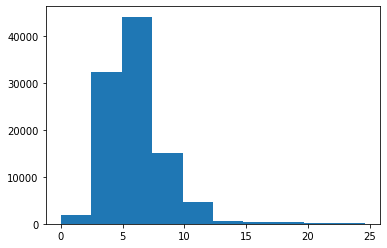

In [33]:
num_samples = 100000
rnd_idx1 = np.random.randint(X_train.shape[0],size=(num_samples, ))
rnd_idx2 = np.random.randint(X_train.shape[0],size=(num_samples, ))
#x_train_rff = [X_train[rnd_idx1], X_train[rnd_idx2]]
x_train_rff = np.concatenate([X_train[rnd_idx1][:, np.newaxis, ...], 
                          X_train[rnd_idx2][:, np.newaxis, ...]], 
                         axis=1) 
dists = np.linalg.norm(x_train_rff[:, 0, ...] - x_train_rff[:, 1, ...], axis=1)
print(dists.shape)
pl.hist(dists)
print(np.quantile(dists, 0.001))
rnd_idx1 = np.random.randint(X_test.shape[0],size=(num_samples, ))
rnd_idx2 = np.random.randint(X_test.shape[0],size=(num_samples, ))
#x_test_rff = [X_test[rnd_idx1], X_test[rnd_idx2]]
x_test_rff = np.concatenate([X_test[rnd_idx1][:, np.newaxis, ...], 
                          X_test[rnd_idx2][:, np.newaxis, ...]], 
                         axis=1) 

In [34]:
def gauss_kernel_arr(x, y, gamma):
    return np.exp(-gamma * np.linalg.norm(x - y, axis=1) ** 2)

[1.000000e+00 5.000000e-01 2.500000e-01 1.250000e-01 6.250000e-02
 3.125000e-02 1.562500e-02 7.812500e-03 3.906250e-03 1.953125e-03
 9.765625e-04]
Gamma: 0.015625
6250/6250 [==============================] - 16s 2ms/step - loss: 0.0542


0.05419857054948807

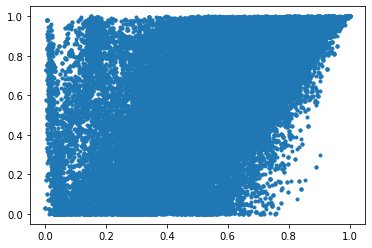

In [35]:
sigma = np.quantile(dists, 0.01)
gamma = 1/(2 * sigma ** 2)
gamma_index = 6 # index 7 corresponds to gamma = 2**(-7)
gammas = 1/(2**(np.arange(11)))
print(gammas)
n_rffs = 4
print(f'Gamma: {gammas[gamma_index ]}') 
y_train_rff = gauss_kernel_arr(x_train_rff[:, 0, ...], x_train_rff[:, 1, ...], gamma=gammas[gamma_index]) # gamma without square
y_test_rff = gauss_kernel_arr(x_test_rff[:, 0, ...], x_test_rff[:, 1, ...], gamma=gammas[gamma_index]) # gamma without square
dmrff = DMRFF(dim_x=21, num_rff=n_rffs, gamma=gammas[gamma_index ]/2, random_state=np.random.randint(10000)) # original rs = 0
dm_rbf = calc_rbf(dmrff, x_test_rff[:, 0, ...], x_test_rff[:, 1, ...])
pl.plot(y_test_rff, dm_rbf, '.')
dmrff.compile(optimizer="adam", loss='mse')
dmrff.evaluate(x_test_rff, y_test_rff, batch_size=16)

Mean: -0.0464983768761158
Std: 0.9478684663772583
Gamma: 0.0078125


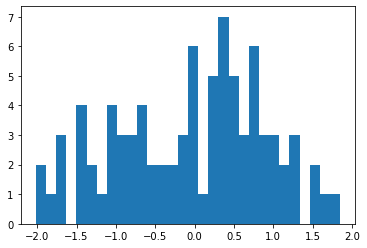

In [36]:
print(f'Mean: {np.mean(dmrff.rff_layer.rff_weights)}')
print(f'Std: {np.std(dmrff.rff_layer.rff_weights)}')
print(f'Gamma: {dmrff.rff_layer.gamma_val.numpy()}')
pl.hist(dmrff.rff_layer.rff_weights.numpy().flatten(), bins=30);

In [37]:
dmrff.fit(x_train_rff, y_train_rff, validation_split=0.1, epochs=40, batch_size=128)

Epoch 1/40
704/704 [==============================] - 5s 5ms/step - loss: 0.0406 - val_loss: 0.0330
Epoch 2/40
704/704 [==============================] - 2s 3ms/step - loss: 0.0297 - val_loss: 0.0263
Epoch 3/40
704/704 [==============================] - 3s 4ms/step - loss: 0.0233 - val_loss: 0.0203
Epoch 4/40
704/704 [==============================] - 2s 3ms/step - loss: 0.0183 - val_loss: 0.0164
Epoch 5/40
704/704 [==============================] - 2s 3ms/step - loss: 0.0157 - val_loss: 0.0148
Epoch 6/40
704/704 [==============================] - 1s 2ms/step - loss: 0.0146 - val_loss: 0.0141
Epoch 7/40
704/704 [==============================] - 1s 2ms/step - loss: 0.0140 - val_loss: 0.0137
Epoch 8/40
704/704 [==============================] - 1s 2ms/step - loss: 0.0137 - val_loss: 0.0134
Epoch 9/40
704/704 [==============================] - 1s 2ms/step - loss: 0.0134 - val_loss: 0.0132
Epoch 10/40
704/704 [==============================] - 1s 2ms/step - loss: 0.0133 - val_loss: 0.0130

782/782 [==============================] - 2s 3ms/step - loss: 0.0140


0.013986421748995781

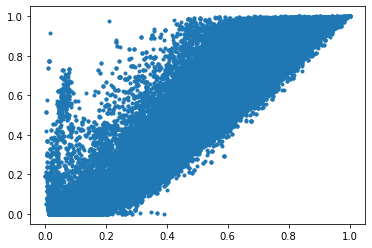

In [38]:
dm_rbf = calc_rbf(dmrff, x_test_rff[:, 0, ...], x_test_rff[:, 1, ...])
pl.plot(y_test_rff, dm_rbf, '.')
dmrff.evaluate(x_test_rff, y_test_rff, batch_size=128)

Mean: 0.11721442639827728
Std: 0.5020942687988281
Gamma: 0.0078125


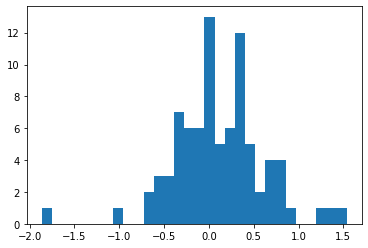

In [39]:
print(f'Mean: {np.mean(dmrff.rff_layer.rff_weights)}')
print(f'Std: {np.std(dmrff.rff_layer.rff_weights)}')
print(f'Gamma: {dmrff.rff_layer.gamma_val.numpy()}')
pl.hist(dmrff.rff_layer.rff_weights.numpy().flatten(), bins=30);

In [40]:
X_feat_train = dmrff.rff_layer.call(tf.cast(X_train, tf.float32))
X_feat_test = dmrff.rff_layer.call(tf.cast(X_test, tf.float32))
X_feat_val = dmrff.rff_layer.call(tf.cast(X_val, tf.float32))

X_feat_train = np.float64((X_feat_train).numpy())
X_feat_test = np.float64((X_feat_test).numpy())
X_feat_val = np.float64((X_feat_val).numpy())

X_feat_train = X_feat_train / np.linalg.norm(X_feat_train, axis = 1).reshape(-1, 1)
X_feat_test = X_feat_test / np.linalg.norm(X_feat_test, axis = 1).reshape(-1, 1)
X_feat_val = X_feat_val / np.linalg.norm(X_feat_val, axis = 1).reshape(-1, 1)

X_feat_train.shape, X_feat_test.shape, X_feat_val.shape

((1098, 4), (367, 4), (366, 4))

## Classical Pred AdpRFF

In [41]:
from sklearn.metrics import roc_curve, f1_score
from sklearn.metrics import classification_report

def classification(preds_val, preds_test, y_test):

    thredhold = np.percentile(preds_val, q = 9.54)
    y_pred = preds_test > thredhold
    return classification_report(y_test, y_pred, digits=4)

In [42]:
gamma = dmrff.rff_layer.gamma_val.numpy()
dim = n_rffs

print(f"{dim}x{dim} Pure, experiment AdaptiveRFF")
print("Gamma:", gamma)

## Training pure state and create the Unitary matrix to initialize such state

psi_train = X_feat_train.sum(axis = 0)
psi_train = psi_train / np.linalg.norm(psi_train)

preds_val_expected = np.sqrt((X_feat_val @ psi_train)**2)
preds_test_expected = np.sqrt((X_feat_test @ psi_train)**2)

print(classification(preds_val_expected, preds_test_expected, y_test))
print(f"AUC = {round(roc_auc_score(y_test, preds_test_expected), 4)}")

4x4 Pure, experiment AdaptiveRFF
Gamma: 0.0078125
              precision    recall  f1-score   support

         0.0     0.7027    0.7429    0.7222        35
         1.0     0.9727    0.9669    0.9698       332

    accuracy                         0.9455       367
   macro avg     0.8377    0.8549    0.8460       367
weighted avg     0.9470    0.9455    0.9462       367

AUC = 0.9571


In [43]:
gamma = dmrff.rff_layer.gamma_val.numpy()
dim = n_rffs

print(f"{dim}x{dim} mixed, experiment AdaptiveRFF")
print("Gamma:", gamma)

## Training mixed state and create the Unitary matrix to initialize such state
rho_train = np.zeros((dim, dim))


#for i in range(1000):
for i in range(len(X_feat_train)):
  rho_train += np.outer(X_feat_train[i], X_feat_train[i])

rho_train = rho_train / len(X_feat_train)

# Classical prediction
preds_val_mixed = np.zeros(len(X_feat_val))

for i in range(len(X_feat_val)):
  preds_val_mixed[i] = X_feat_val[i].T @ rho_train @ X_feat_val[i]

preds_test_mixed = np.zeros(len(X_feat_test))

for i in range(len(X_feat_test)):
  preds_test_mixed[i] = X_feat_test[i].T @ rho_train @ X_feat_test[i]

print(classification(preds_val_mixed, preds_test_mixed, y_test))
print(f"AUC = {round(roc_auc_score(y_test, preds_test_mixed), 4)}")

4x4 mixed, experiment AdaptiveRFF
Gamma: 0.0078125
              precision    recall  f1-score   support

         0.0     0.6944    0.7143    0.7042        35
         1.0     0.9698    0.9669    0.9683       332

    accuracy                         0.9428       367
   macro avg     0.8321    0.8406    0.8363       367
weighted avg     0.9435    0.9428    0.9431       367

AUC = 0.956


## Quantum Simulator Pred AdpRFF

In [47]:
def quantum_circuit_mixed(Ctest, eigvals, U_train, n_shots=10000, n_rffs = 16):

    num_qubits = int(np.log2(n_rffs)) # qubits to initialize
    qb_ls = [l for l in range(num_qubits)] # (0, 1, .., n-1)
    qb_ls2 = [l + num_qubits for l in range(num_qubits)] # (n, n+1, ..., 2*n-1)
    print(num_qubits)
    Cpred = []
    for i in range(len(Ctest)):
        qc = QuantumCircuit(2*num_qubits, num_qubits)

        qc.initialize(Ctest[i], qb_ls)
        qc.initialize(np.sqrt(eigvals), qb_ls2)
        qc.isometry(U_train.T, [], qb_ls) # ArbRot as a isometry

        for j in range(num_qubits):
          qc.cnot(j+num_qubits, j)

        for k in range(num_qubits):
          qc.measure(k, k)

        counts = execute(qc, backend2, shots=n_shots).result().get_counts()
        try:
            Cpred.append(counts['0'*num_qubits] / n_shots)
        except:
            Cpred.append(0)

    return Cpred


def quantum_circuit_pure(Ctest, U_train, n_shots=10000, n_rffs = 16):
    
    num_qubits = int(np.log2(n_rffs)) # num qubits to initialize
    print(num_qubits)
    qb_ls = [l for l in range(num_qubits)] # (0, 1, .., n-1)
    Cpred = []
    for i in range(len(Ctest)):
        qc = QuantumCircuit(num_qubits, num_qubits)
        qc.initialize(Ctest[i], qb_ls )
        qc.isometry(U_train.T, [], qb_ls )
        for k in range(num_qubits):
          qc.measure(k, k)

        counts = execute(qc, backend2, shots=n_shots).result().get_counts()
        try:
            Cpred.append(np.sqrt(counts['0'*num_qubits] / n_shots))
        except:
            Cpred.append(0)

    return Cpred

In [48]:
backend2 = Aer.get_backend('qasm_simulator')
exp_time = time()
n_rff = n_rffs
print(f"{n_rff}x{n_rff} Pure, experiment")
print("Gamma:", dmrff.rff_layer.gamma_val.numpy())
U = pure_state(X_feat_train)

preds_val = quantum_circuit_pure(X_feat_val, U, 10000, n_rff)
preds_test = quantum_circuit_pure(X_feat_test, U, 10000, n_rff)

print(classification(preds_val, preds_test, y_test))
print(f"AUC = {round(roc_auc_score(y_test, preds_test), 4)}")
print(time() - exp_time)
exp_time = time()

4x4 Pure, experiment
Gamma: 0.0078125
2
2
              precision    recall  f1-score   support

         0.0     0.7027    0.7429    0.7222        35
         1.0     0.9727    0.9669    0.9698       332

    accuracy                         0.9455       367
   macro avg     0.8377    0.8549    0.8460       367
weighted avg     0.9470    0.9455    0.9462       367

AUC = 0.9569
79.42946267127991


In [ ]:
backend2 = Aer.get_backend('qasm_simulator')
exp_time = time()
n_rff = n_rffs
print(f"{n_rff}x{n_rff} Mixed, experiment")
print("Gamma:", dmrff.rff_layer.gamma_val.numpy())

eigvals, U = mixed_state(X_feat_train)

preds_val = quantum_circuit_mixed(X_feat_val, eigvals, U, 10000, n_rff)
preds_test = quantum_circuit_mixed(X_feat_test, eigvals, U, 10000, n_rff)

print(classification(preds_val, preds_test, y_test))
print(f"AUC = {round(roc_auc_score(y_test, preds_test), 4)}")
print(time() - exp_time)
exp_time = time()

4x4 Mixed, experiment
Gamma: 0.0078125
2
